In [1]:
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size':16})

import sciunit
from owtests import OW_HOME
import wcon
import open_worm_analysis_toolbox as owat

In [2]:
OWAT_TESTS = os.path.join(OW_HOME,'tests','owtests','open-worm-analysis-toolbox')

# Model classes

In [3]:
class HasFeatures(sciunit.Capability):
    def get_feature_stat(self, feature, stat):
        raise NotImplementedError()

In [4]:
class MovementModel(sciunit.Model,HasFeatures):
    """Model class for testing worm movement"""
    
    def __init__(self, path, name=None, attrs=None):
        super(MovementModel,self).__init__(name)
        self.path = path
        # Only needed for API compliance
        self.attrs = attrs if attrs else {}
        self.run_params = {}
        self.url = 'http://github.com/openworm/tests'
           
    # Mapping between traditional feature names and OWAT feature names
    # for ten core features
    feature_map = \
        {'area':None,
         'forward_frequency':'locomotion.motion_events.forward.frequency',
         'backward_frequency':'locomotion.motion_events.backward.frequency',
         'head_tip_speed_abs':'locomotion.velocity.head_tip.speed',
         'length':'morphology.length',
         'max_amplitude':'posture.amplitude_max',
         'midbody_bend_mean_abs':'posture.bends.midbody.mean',
         'midbody_speed_abs':'locomotion.velocity.midbody.speed',
         'path_range':None,
         'paused_frequency':'locomotion.motion_events.paused.frequency'}
    
    def extract_features(self):
        self.features = owat.WormFeatures.from_disk(self.path)
        
    def compute_feature_stats(self):
        feature_list = list(self.features._features.keys())
        # Make a data frame to store feature stats
        self.feature_stats = pd.DataFrame(index=feature_list,columns=['mean'])
        for stat in list(self.feature_stats):
            n_valid = 0
            for feature,value in self.features._features.items():
                try: # Fill with feature means only if 
                     # the feature is found and has some numeric data
                    f = getattr(pd.Series(value.value),stat)
                    result = f()
                    if not np.isnan(result):
                        self.feature_stats.loc[feature,stat] = result
                        n_valid += 1
                except:
                    pass
            # Valid features are the ones that were computed and have some numeric data
            print("%d valid feature values found for %s" % (n_valid,stat))
        self.feature_stats = self.feature_stats.astype('float')
        
    def get_feature_stat(self, feature, stat):
        s = self.feature_stats[stat]
        if feature in s:
            result = s[feature]
        elif feature in self.feature_map:
            alt_feature = self.feature_map[feature]
            if alt_feature in s:
                result = s[alt_feature]
            else:
                raise KeyError("Couldn't find an entry for %s or %s" % (feature,alt_feature))
        else:
            raise KeyError("Couldn't find an entry for %s" % feature)
        return result
        
    def get_amplitude_ratio(self):
        return self.get_feature_stat('posture.amplitude_ratio',
                                     'mean')

In [5]:
import pandas as pd
path = os.path.join(OWAT_TESTS,'experiment','movement_feature_means_all.csv')
df = pd.read_csv(path,index_col=0)
for col in MovementModel.feature_map.keys():
    try:
        df = df[df[col] != 'None']
        df[col] = df[col].astype('float')
    except:
        pass
df.head()

,strain,gene,allele,zenodo_id,timestamp,tail_tip_motion_direction_backward_abs,area_length_ratio_paused,area_length_ratio_forward,hips_bend_mean_forward,midbody_motion_direction_neg,...,midbody_motion_direction_forward_abs,tail_speed_paused_abs,eigen_projection_2,amplitude_ratio_paused,inter_upsilon_turns_distance_neg,eigen_projection_6_forward_abs,backward_distance_ratio,midbody_crawling_frequency_forward_neg,tail_to_head_orientation_backward_neg,inter_paused_distance
base_name,,,,,,,,,,,,,,,,,,,,,
mec-12 (e1605) on food L_2010_10_01__12_25_25___6___3,AQ1031,mec-12,e1605,1003312,2010-10-01 12:25,85.3053,74.6316,72.4349,1.92982,-36.9678,...,50.1217,11.2033,0.417755,0.664443,None,0.215237,0.0982003,-0.26469,-82.0815,1601.19
mec-12 (e1605) on food R_2010_11_04__10_58_31___6___2,AQ1031,mec-12,e1605,1003424,2010-11-04 10:58,90.1372,77.1482,77.1331,-0.959241,-36.5956,...,41.7723,16.778,-0.065957,0.678501,None,0.21727,0.14207,-0.200722,-83.2691,1903.87
mec-12 (e1605) on food L_2010_10_21__12_46_27___6___,AQ1031,mec-12,e1605,1005542,2010-10-21 12:46,76.4708,71.2596,71.5647,-0.969506,-19.9990,...,33.717,12.9652,-0.313908,0.670223,None,0.257123,0.358074,-0.179891,-103.594,352.74
mec-12 (e1605) on food L_2010_10_28__12_37_10___6___6,AQ1031,mec-12,e1605,1006072,2010-10-28 12:37,62.9685,83.3254,76.8357,-4.37694,-16.8998,...,34.3612,12.6223,-0.847515,0.689994,None,0.206636,0.240402,-0.176759,-109.987,369.607
mec-12 (e1605) on food R_2010_09_30__12_26_02___6___7,AQ1031,mec-12,e1605,1006144,2010-09-30 12:26,88.3296,76.6559,73.8905,0.0668615,-43.9411,...,49.7322,15.5022,0.013741,0.752864,None,0.176876,0.155526,-0.26047,-79.1087,3453.44


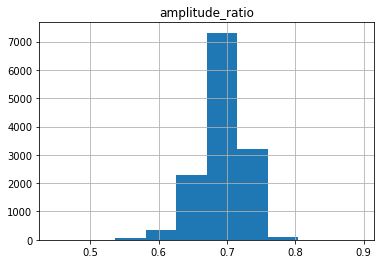

In [6]:
df.hist(['amplitude_ratio']);

In [7]:
#model_path = os.path.join(OWAT_TESTS,'model','worm_motion_log.wcon')
#model_long = MovementModel(model_path,name='Long Model')
#%time model_long.extract_features()
#%time model_long.compute_feature_stats()

model_path = os.path.join(OWAT_TESTS,'model','worm_motion_log_short.wcon')
model_short = MovementModel(model_path,name='sibernetic_c302_short')
%time model_short.extract_features()
%time model_short.compute_feature_stats()

#models = [model_long, model_short]
models = [model_short]

Loading file: /Users/rgerkin/Dropbox/dev/openworm/tests/owtests/open-worm-analysis-toolbox/model/worm_motion_log_short.wcon
CPU times: user 212 ms, sys: 3.26 ms, total: 215 ms
Wall time: 217 ms
42 valid feature values found for mean
CPU times: user 34.3 ms, sys: 1.42 ms, total: 35.7 ms
Wall time: 34.7 ms


In [8]:
model_short.feature_stats.loc['morphology.length']

mean    1103.626737
Name: morphology.length, dtype: float64

In [9]:
class MovementFeatureTest(sciunit.Test): 
    """Base class for movement feature tests"""
    
    score_type = sciunit.scores.ZScore   
    attribute = None
    
    def validate_observation(self, observation):
        for col in ['mean','std']:
            s = observation['df'][self.attribute]
            
            f = getattr(observation['df'][self.attribute],col)
            print(self.attribute,col)
            observation[col] = f()
        return observation
        
    def generate_prediction(self, model):
        mean = model.get_feature_stat(self.attribute,'mean')
        if self.name.endswith('absTest'):
            mean = np.abs(mean)
        return mean#{'mean': mean}
    
def test_factory(attribute):
    class C(MovementFeatureTest):
        attribute = attribute
    C.__name__ = '%sTest' % attribute
    return C

In [10]:
tests = []
for attribute in MovementModel.feature_map:
    if MovementModel.feature_map[attribute] is not None:
        cls = test_factory(attribute)
        tests.append(cls(observation={'df':df}))
suite = sciunit.TestSuite(tests)

paused_frequency mean
paused_frequency std
midbody_speed_abs mean
midbody_speed_abs std
length mean
length std
backward_frequency mean
backward_frequency std
max_amplitude mean
max_amplitude std
midbody_bend_mean_abs mean
midbody_bend_mean_abs std
forward_frequency mean
forward_frequency std
head_tip_speed_abs mean
head_tip_speed_abs std


In [11]:
score_matrix = suite.judge(models,stop_on_error=False)

In [12]:
for score in score_matrix[models[0]]:
    print(score.test.name,score.observation['mean'],score.prediction)

paused_frequencyTest 0.1447911359226569 nan
midbody_speed_absTest 86.95422165158202 131.9501842222467
lengthTest 1108.5587105243474 1103.626737030518
backward_frequencyTest 0.05681460370483955 nan
max_amplitudeTest 219.02983095220281 193.66399575731685
midbody_bend_mean_absTest 10.550484196274963 11.754018770888111
forward_frequencyTest 0.0819841420008976 nan
head_tip_speed_absTest 134.4455244259107 279.04472657578856


In [13]:
score_matrix.T

,sibernetic_c302_short
paused_frequencyTest,Insufficient Data
midbody_speed_absTest,Z = 0.68
lengthTest,Z = -0.03
backward_frequencyTest,Insufficient Data
max_amplitudeTest,Z = -0.60
midbody_bend_mean_absTest,Z = 0.48
forward_frequencyTest,Insufficient Data
head_tip_speed_absTest,Z = 1.88


In [14]:
from scidash_api import client
client_instance = client.ScidashClient({'base_url': 'http://scidash.a88dc6aa.svc.dockerapp.io:8000'}, 
                                       hostname="Workuity Dell")
client_instance.login(username='openworm', password='passworm')

In [15]:
score = score_matrix['sibernetic_c302_short']['lengthTest']

In [16]:
del score.test.observation['df']

In [17]:
x = score.json(exclude=[('test','observation','df')],add_props=True,indent=2)
print(x)

{
  "model": {
    "features": "         timer: Type...",
    "unpicklable": [],
    "_class": {
      "name": "MovementModel",
      "url": ""
    },
    "params": {},
    "name": "sibernetic_c302_short",
    "url": "http://github.com/openworm/tests",
    "path": "/Users/rgerkin/Dropbox/dev/openworm/tests/owtests/open-worm-analysis-toolbox/model/worm_motion_log_short.wcon",
    "run_params": {},
    "attrs": {},
    "capabilities": [
      "HasFeatures"
    ],
    "feature_stats": {
      "data": [
        [
          1103.626737030518
        ],
        [
          -110.73571295993229
        ],
        [
          NaN
        ],
        [
          -279.04472657578856
        ],
        [
          29.976633900945426
        ],
        [
          NaN
        ],
        [
          -254.72402718180945
        ],
        [
          23.920223204324806
        ],
        [
          NaN
        ],
        [
          -131.9501842222467
        ],
        [
          -42.62171347812155

In [18]:
r = client_instance.upload_score(score)

In [19]:
r.reason

'Created'

In [20]:
from pprint import pprint
pprint(r.json())

{'data': {'id': 50,
          'model_instance': {'attributes': {},
                             'id': 50,
                             'model_class': {'capabilities': [{'class_name': 'HasFeatures',
                                                               'id': 220}],
                                             'class_name': 'MovementModel',
                                             'id': 50,
                                             'url': ''},
                             'name': 'sibernetic_c302_short',
                             'run_params': {},
                             'url': 'http://github.com/openworm/tests'},
          'owner': {'date_joined': '2018-03-28T15:14:45.147468',
                    'email': '',
                    'first_name': '',
                    'groups': [],
                    'id': 5,
                    'is_active': True,
                    'is_staff': False,
                    'is_superuser': False,
                    'last_login': No

In [21]:
for test in suite.tests:
    try:
        del test.observation['df']
    except:
        pass

In [22]:
client_instance.upload_suite(suite,score_matrix)

AttributeError: 'str' object has no attribute 'get'

In [27]:
for score in score_matrix['sibernetic_c302_short']:
    if score.raw is not None:
        client_instance.upload_score(score)